In [1]:
from typing import Dict, Union

#model_general
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
from torch_geometric.data import Data
from torch_cluster import radius_graph
from torch_scatter import scatter
import torch_scatter

#e3nn
import e3nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace
from e3nn.nn import FullyConnectedNet, Gate
#from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists
from e3nn.o3 import TensorProduct, Linear, FullyConnectedTensorProduct
from e3nn.util.jit import compile_mode

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from ase import io

#other
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import math
import time
from tqdm import tqdm
import numpy as np
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
textsize = 14
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

In [2]:
from _GraphNW import PeriodicNetwork, Network
import _Convolution
from _Training import train, evaluate
from Data_processing import Processing, get_neighbors
from Split_dat import split_tvt, split_tt
from Besel_basis import BesselBasis

In [3]:
r_max = 4
chemical_symbol = ["Ti", "O"]

In [4]:
build_data = Processing(r_max = r_max, chemical_symbols = chemical_symbol)
data = build_data('input.xyz')

In [5]:
d_load_train, d_load_val, d_load_test = split_tvt(data, train_size=0.8, valid_size=0.1, test_size=0.1)
#d_load_train, d_load_val = split_tt(data, train_size=0.8)

In [6]:
n_train = get_neighbors(d_load_train.dataset)

In [4]:
# for evaluation
n_train = get_neighbors(data)

In [7]:
out_dim = 1
em_dim = 32
att_dim = len(chemical_symbol)

model = PeriodicNetwork(
    in_dim=att_dim,           # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(att_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=4,                              # number of nonlinearities (number of convolutions = layers)
    mul=32,                                # multiplicity of irreducible representations
    lmax=1,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean() #num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    #reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

PeriodicNetwork(
  (basis): BesselBasis()
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e x 2x0e -> 64x0e+32x1o | 4096 paths | 4096 weights)
        (lin1): Linear(32x0e -> 32x0e | 1024 weights)
        (fc): FullyConnectedNet[8, 64, 64, 64]
        (tp): TensorProduct(32x0e x 1x0e+1x1o -> 32x0e+32x1o | 64 paths | 64 weights)
        (lin2): Linear(32x0e+32x1o -> 64x0e+32x1o | 3072 weights)
      )
      (second): Gate (64x0e+32x1o -> 32x0e+32x1o)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o x 2x0e -> 96x0e+32x1o+32x1e | 8192 paths | 8192 weights)
        (lin1): Linear(32x0e+32x1o -> 32x0e+32x1o | 2048 weights)
        (fc): FullyConnectedNet[8, 64, 64, 160]
        (tp): TensorProduct(32x0e+32x1o x 1x0e+1x1o -> 64x0e+64x1o+32x1e | 160 paths | 160 weights)
        (lin2): Linear(64x0e+64x1o+32x1e -> 96x0e+32x1o+32x1e | 9216 weights)
      )
   

/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/Users/dndung/anaconda3/envs/e3mm/lib/python3.10/site-packages/torch/jit/_check.py:178: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn

In [9]:
sum(p.numel() for p in model.parameters())

154232

In [29]:
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
fontsize = 18

def plot_example(df, i=0, label_edges=False):
    # plot an example crystal structure and graph
    entry = df[i]

    # get graph with node and edge attributes
    g = tg.utils.to_networkx(entry, node_attrs=['symbol'], edge_attrs=['edge_len'], to_undirected=True)

    # remove self-loop edges for plotting
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    node_labels = dict(zip([k[0] for k in g.nodes.data()], [k[1]['symbol'] for k in g.nodes.data()]))
    edge_labels = dict(zip([(k[0], k[1]) for k in g.edges.data()], [k[2]['edge_len'] for k in g.edges.data()]))

    # project positions of nodes to 2D for plotting
    pos = dict(zip(list(g.nodes), [np.roll(k,2)[:-1][::-1] for k in entry.pos.numpy()]))

    # plot unit cell
    fig, ax = plt.subplots(1,2, figsize=(18,14), gridspec_kw={'width_ratios': [2,3]})
    atoms = Atoms(symbols=entry.symbol, positions=entry.pos.numpy(), cell=entry.lattice.squeeze().numpy(), pbc=True)
    symbols = np.unique(entry.symbol)
    z = dict(zip(symbols, range(len(symbols))))
    norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
    color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in entry.symbol]))]
    plot_atoms(atoms, ax[0], radii=0.25, colors=color, rotation=('0x,90y,0z'))

    # plot graph
    nx.draw_networkx(g, ax=ax[1], labels=node_labels, pos=pos, node_size=500, node_color=color,
                     edge_color='gray')
    
    if label_edges:
        nx.draw_networkx_edge_labels(g, ax=ax[1], edge_labels=edge_labels, pos=pos, label_pos=0.5)
    
    # format axes
    ax[0].set_xlabel(r'$x_1\ (\AA)$', fontsize = 13)
    ax[0].set_ylabel(r'$x_2\ (\AA)$')
    ax[0].set_title('Crystal structure', fontsize=fontsize)
    ax[1].set_aspect('equal')
    ax[1].axis('off')
    ax[1].set_title('Crystal graph', fontsize=fontsize)
    pad = np.array([-0.5, 0.5])
    ax[1].set_xlim(np.array(ax[1].get_xlim()) + pad)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) + pad)
    fig.subplots_adjust(wspace=0.4)

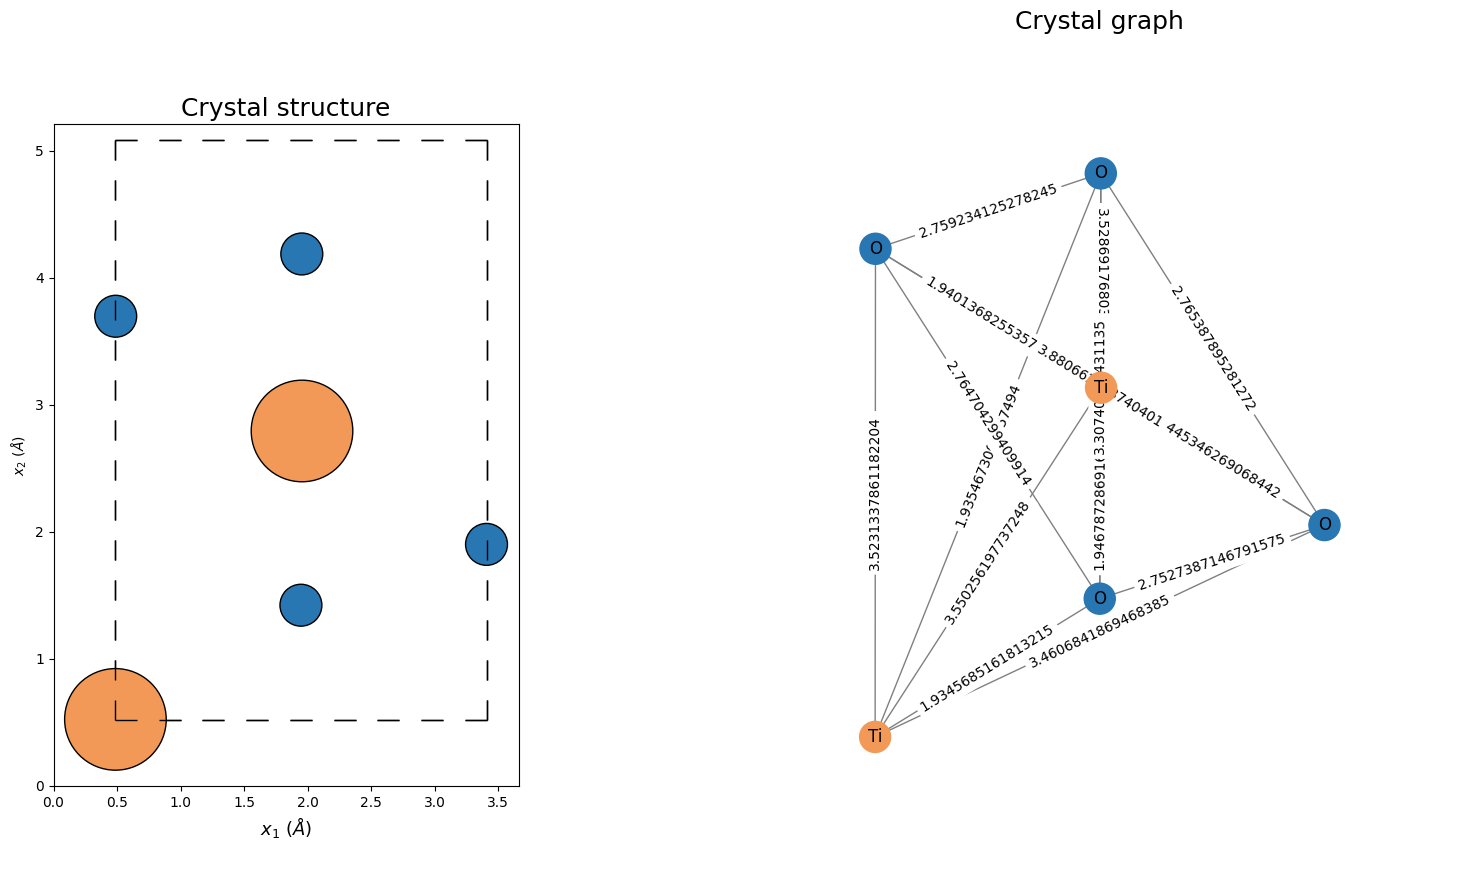

In [30]:
plot_example(data, 0, label_edges=True)

In [8]:
opt = torch.optim.Adam(model.parameters(),  betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, maximize=False, lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=100, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()
loss_fn_mse = torch.nn.MSELoss()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

run_name = 'model_' + time.strftime("%y%m%d", time.localtime())
print(run_name)

torch device: cpu
model_241225


In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)
# run_name = 'model_241214'

torch device: cpu


In [20]:
next(model.parameters()).device

device(type='cpu')

In [11]:
train(model, opt, d_load_train, d_load_val, loss_fn, loss_fn_mae, loss_fn_mse, run_name,
      max_epoch=2, scheduler=scheduler, device=device)

/Users/dndung/Desktop/MEGNET/NequIP/Simp_nequip/_Training.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  try: check_point = torch.load(run_name + '.torch')
100%|██████

elapsed time = 00:01:02    Best epoch:    1


100%|██████████| 960/960 [01:04<00:00, 14.81it/s]


elapsed time = 00:02:33    Best epoch:    2


In [6]:
model = torch.load('best_model.pth')

/var/folders/mp/45b1mfk91r197n5vmxp2jvmw0000gn/T/ipykernel_74552/2808078871.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model.pth')


In [8]:
import copy
model.eval()
dat = copy.deepcopy(data)
model(dat[0])

(tensor([-58.6224], grad_fn=<SumBackward1>),
 tensor([[-10.6382],
         [-10.6447],
         [ -9.3204],
         [ -9.3514],
         [ -9.3379],
         [ -9.3299]], grad_fn=<ViewBackward0>),
 tensor([[-0.0486,  0.1408, -0.0050],
         [ 0.0840, -0.1542, -0.0086],
         [-0.0358,  0.0438, -0.0355],
         [ 0.0437, -0.0665,  0.0292],
         [-0.0093,  0.0294,  0.0520],
         [-0.0340,  0.0066, -0.0321]]))

In [18]:
import copy
dat_train = copy.deepcopy(d_load_train.dataset)
dat_val = copy.deepcopy(d_load_val.dataset)

def evaluate(model, dataloader, loss_fn, loss_fn_mae, loss_fn_mse, device):
    model.eval()
    loss_cumulative = 0.
    mae_cumulative_e = 0.
    mae_cumulative_f = 0.
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            out_e, _, out_f = model(d)
            loss_e = loss_fn(out_e, d.energy).cpu()
            loss_f = loss_fn(out_f, d.force).cpu() #loss of force, the weight is for checking, should be change later
            loss_mae_e = loss_fn_mae(out_e, d.energy).cpu()
            loss_mae_f = loss_fn_mae(out_f, d.force).cpu()
            mae_cumulative_e = mae_cumulative_e + loss_mae_e.detach().item()
            mae_cumulative_f = mae_cumulative_f + loss_mae_f.detach().item()
            loss_cumulative = loss_cumulative + loss_e.detach().item()/36 + loss_f.detach().item()
    return loss_cumulative / len(dataloader), mae_cumulative_e / len(dataloader), mae_cumulative_f / len(dataloader)  

In [19]:
evaluate(model, dat_train, loss_fn, loss_fn_mae, loss_fn_mse, device)

(4.635109369143529e-05, 0.008822155332208544, 0.005013112913854304)

In [20]:
evaluate(model, dat_val, loss_fn, loss_fn_mae, loss_fn_mse, device)

(4.3195344442014335e-05, 0.009316054166414567, 0.004835247868658001)

In [21]:
dat_train = copy.deepcopy(d_load_train.dataset)
dat_val = copy.deepcopy(d_load_val.dataset)

In [22]:
evaluate(model, dat_train, loss_fn, loss_fn_mae, loss_fn_mse, device)

(4.635109369143529e-05, 0.008822155332208544, 0.005013112913854304)

/var/folders/mp/45b1mfk91r197n5vmxp2jvmw0000gn/T/ipykernel_1822/2512619778.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(run_name + '.torch', map_

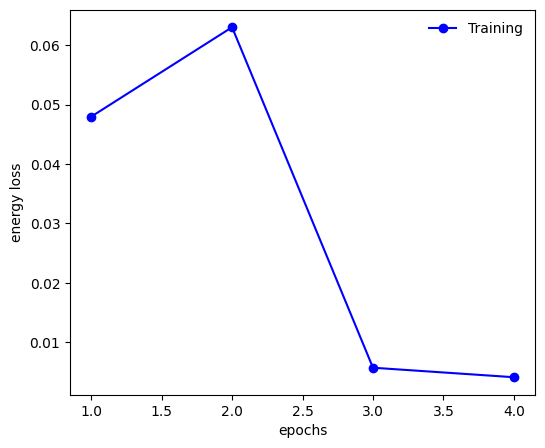

In [13]:
run_name = 'model_241214'

history = torch.load(run_name + '.torch', map_location='cpu')['history'][:]
steps = [d['epoch'] + 1 for d in history]
loss_train = [d['batch']['loss'] for d in history]
#loss_valid = [d['batch']['loss_e'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color='blue')
#ax.plot(steps, loss_valid, 'o-', label="Validation", color='orange')
ax.set_xlabel('epochs')
ax.set_ylabel('energy loss')
ax.legend(frameon=False);

In [11]:
# run_name = 'model_241119'

history = torch.load(run_name + '.torch', map_location='cpu', weights_only=True)['history'][1:]
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss_f'] for d in history]
loss_valid = [d['valid']['loss_f'] for d in history]

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(steps, loss_train, 'o-', label="Training", color='blue')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='orange')
ax.set_xlabel('epochs')
ax.set_ylabel('force loss')
ax.legend(frameon=False);

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options 
	(1) Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([scalar])` to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [13]:
d_load_train.dataset[0].lattice

tensor([[[4.6158, 0.0000, 0.0000],
         [0.0000, 4.6158, 0.0000],
         [0.0000, 0.0000, 2.9429]]])

In [15]:
#force
#class

def force(data):
    data = data.clone()
    
    def wrapper(pos: torch.Tensor) -> torch.Tensor:
        #nonlocal data
        pbc = np.array([ True,  True,  True])
        lat = data.lattice
        edge_index, edge_shift, edge_vec, edge_len = to_edge(lat=lat, pos=pos, r_max=4, pbc=pbc)
        data.edge_vec = edge_vec
        data.edge_index = edge_index
        data.edge_shift = edge_shift
        data.edge_len = edge_len
        out, _, _ = model(data)  
        return out.squeeze(-1)
        
    pos = data.pos
    # pos.requires_grad = True
    # print(pos)
    
    f = torch.autograd.functional.jacobian(
            func=wrapper,
            inputs=pos,
            create_graph=True,  # needed to allow gradients of this output during training
            #vectorize=self.vectorize,
            strict=True
        )
    #print(pos)
    return f

In [16]:
d = data[1].clone()
d.pos

tensor([[2.2822, 2.2835, 1.4572],
        [4.5595, 4.5614, 0.0095],
        [0.8906, 3.6724, 1.4587],
        [3.6638, 0.8974, 1.4684],
        [1.3830, 1.3834, 2.9245],
        [3.1797, 3.1864, 0.0089]])

In [16]:
force(d).sum(dim = 0)

tensor([[[ 0.0394,  0.0461, -0.0136],
         [-0.0151, -0.0360,  0.0199],
         [-0.9327,  0.9191, -0.0253],
         [ 0.9177, -0.9298,  0.0057],
         [ 0.7252,  0.6906, -0.0118],
         [-0.7346, -0.6899,  0.0251]]], grad_fn=<SumBackward1>)

In [17]:
force(d)

tensor([[ 7.9011e-02,  1.0018e-01,  7.7955e-02],
        [-6.5245e-02, -2.2059e-02, -8.3447e-02],
        [-1.7027e+00,  1.6693e+00,  1.0660e-02],
        [ 1.7071e+00, -1.7241e+00,  4.2499e-02],
        [ 1.3617e+00,  1.3149e+00, -4.9195e-02],
        [-1.3798e+00, -1.3381e+00,  1.5284e-03]], grad_fn=<ViewBackward0>)

In [11]:
model(d)

(tensor([-1.0512], grad_fn=<SumBackward1>),
 tensor([[ 0.1830],
         [ 0.1446],
         [-0.3480],
         [-0.3548],
         [-0.3312],
         [-0.3449]], grad_fn=<ViewBackward0>),
 tensor([[-7.9011e-02, -1.0018e-01, -7.7955e-02],
         [ 6.5245e-02,  2.2059e-02,  8.3447e-02],
         [ 1.7027e+00, -1.6693e+00, -1.0660e-02],
         [-1.7071e+00,  1.7241e+00, -4.2499e-02],
         [-1.3617e+00, -1.3149e+00,  4.9195e-02],
         [ 1.3798e+00,  1.3381e+00, -1.5284e-03]]))

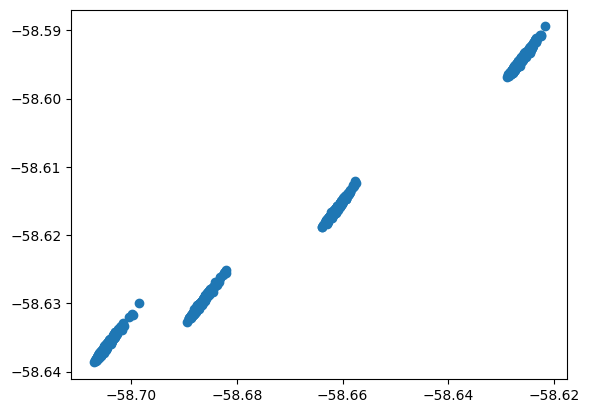

In [10]:
import copy
pred = []
ref = []
dat = copy.deepcopy(data)
for i, d in enumerate(dat):
    pred.append(model(d)[0].detach())
    ref.append(d.energy.detach())

#plt.xlim(-58.64, -58.59)
#plt.ylim(-58.64, -58.59)
plt.scatter(pred, ref)

In [8]:
model.load_state_dict(torch.load('model_241115.torch', map_location='cpu', weights_only=True)['state'])
model.eval()

RuntimeError: Error(s) in loading state_dict for PeriodicNetwork:
	Missing key(s) in state_dict: "layers.0.first.fc.layer2.weight", "layers.1.first.fc.layer2.weight", "layers.2.first.fc.layer2.weight". 
	size mismatch for layers.0.first.fc.layer0.weight: copying a param with shape torch.Size([10, 100]) from checkpoint, the shape in current model is torch.Size([8, 64]).
	size mismatch for layers.0.first.fc.layer1.weight: copying a param with shape torch.Size([100, 128]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for layers.1.first.fc.layer0.weight: copying a param with shape torch.Size([10, 100]) from checkpoint, the shape in current model is torch.Size([8, 64]).
	size mismatch for layers.1.first.fc.layer1.weight: copying a param with shape torch.Size([100, 160]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for layers.2.first.fc.layer0.weight: copying a param with shape torch.Size([10, 100]) from checkpoint, the shape in current model is torch.Size([8, 64]).
	size mismatch for layers.2.first.fc.layer1.weight: copying a param with shape torch.Size([100, 256]) from checkpoint, the shape in current model is torch.Size([64, 64]).

In [11]:
import copy
dat = copy.deepcopy(data)
model(dat[0])

(tensor([-58.7059], grad_fn=<SumBackward1>),
 tensor([[-10.1146],
         [-10.1067],
         [ -9.5923],
         [ -9.6499],
         [ -9.6290],
         [ -9.6134]], grad_fn=<ViewBackward0>),
 tensor([[-0.0710,  0.1618, -0.0183],
         [ 0.0789, -0.1555, -0.0049],
         [-0.0322,  0.0407, -0.0439],
         [ 0.0635, -0.0852,  0.0382],
         [ 0.0027,  0.0408,  0.0650],
         [-0.0419, -0.0027, -0.0360]]))

In [13]:
dat[0].force

tensor([[-0.0615,  0.1621, -0.0116],
        [ 0.0927, -0.1689,  0.0020],
        [-0.0430,  0.0469, -0.0512],
        [ 0.0532, -0.0763,  0.0343],
        [ 0.0071,  0.0415,  0.0680],
        [-0.0485, -0.0052, -0.0414]])

In [14]:
dat[0].energy

tensor([-58.6375])

In [16]:
dat = copy.deepcopy(data)
loss_fn(dat[0].energy, model(dat[0])[0])

tensor(0.0047, grad_fn=<MseLossBackward0>)

In [14]:
d_load_train.dataset[0]

Data(x=[6, 118], edge_index=[2, 140], pos=[6, 3], lattice=[3, 3], symbol=[6], z=[6, 118], edge_shift=[140, 3], edge_vec=[140, 3], edge_len=[140], force=[6, 3], energy=[1])

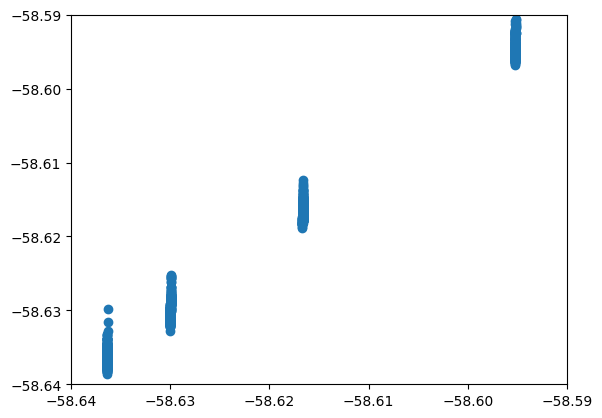

In [15]:
import copy
pred = []
ref = []
dat = copy.deepcopy(d_load_train.dataset)
for i, d in enumerate(dat):
    pred.append(model(d)[0].detach()*y_std + y_m)
    ref.append(d.energy.detach()*y_std + y_m)

plt.xlim(-58.64, -58.59)
plt.ylim(-58.64, -58.59)
plt.scatter(pred, ref)

In [16]:
dat = copy.deepcopy(d_load_train.dataset)
loss_gather = 0
for i, d in enumerate(dat):
    loss_e = loss_fn(model(d)[0].detach(), d.energy)
    loss_gather  = loss_gather + loss_e.detach().item()

In [18]:
loss_gather/len(d_load_train)

0.007301217472653543

In [12]:
dat = copy.deepcopy(data)
print(dat[0].energy)
print(dat[0].force)
model(dat[0])

tensor([-1.1448])
tensor([[-0.0615,  0.1621, -0.0116],
        [ 0.0927, -0.1689,  0.0020],
        [-0.0430,  0.0469, -0.0512],
        [ 0.0532, -0.0763,  0.0343],
        [ 0.0071,  0.0415,  0.0680],
        [-0.0485, -0.0052, -0.0414]])


(tensor([-1.0679], grad_fn=<SumBackward1>),
 tensor([[-0.1674],
         [-0.1508],
         [-0.1370],
         [-0.2394],
         [-0.1992],
         [-0.1742]], grad_fn=<ViewBackward0>),
 tensor([[-0.0496,  0.1641, -0.0149],
         [ 0.0929, -0.1604, -0.0054],
         [-0.0574,  0.0142, -0.0527],
         [ 0.0529, -0.0442,  0.0320],
         [ 0.0039,  0.0059,  0.0749],
         [-0.0426,  0.0205, -0.0339]]))

In [20]:
dat[0].force[:,0]

tensor([-0.0615,  0.0927, -0.0430,  0.0532,  0.0071, -0.0485])

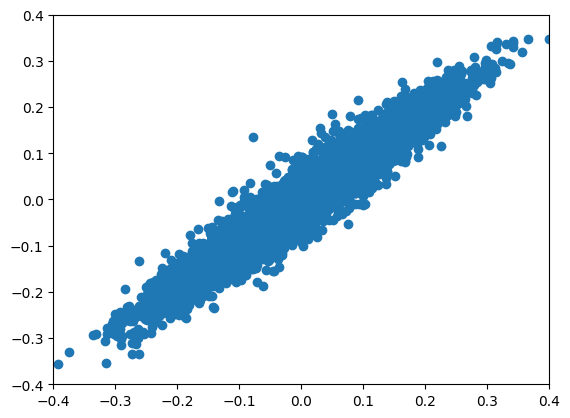

In [13]:
import copy
pred = []
ref = []
dat = copy.deepcopy(data)
for i, d in enumerate(dat):
    pred.append(model(d)[2].detach()[:,0])
    ref.append(d.force[:,0])

plt.xlim(-0.4, 0.4)
plt.ylim(-0.4, 0.4)
plt.scatter(pred, ref)

In [20]:
torch.save(d_load_train, 'train_set.pth')

In [21]:
torch.save(d_load_val, 'val_set.pth')

In [22]:
torch.save(d_load_test, 'test_set.pth')

In [24]:
a = torch.load('train_set.pth')

/var/folders/mp/45b1mfk91r197n5vmxp2jvmw0000gn/T/ipykernel_5357/2974841728.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = torch.load('train_set.pth')


In [9]:
mod2 = BesselBasis(r_max = 4, num_basis=8, trainable=True)
print(mod2)

BesselBasis()


In [10]:
mod2.bessel_weights

Parameter containing:
tensor([ 3.1416,  6.2832,  9.4248, 12.5664, 15.7080, 18.8496, 21.9911, 25.1327],
       requires_grad=True)

In [12]:
start_time = time.time()
for j, d in tqdm(enumerate(d_load_train), total=len(d_load_train), bar_format=bar_format):
            d.to(device)
            out_e, _, out_f = model(d)
            loss_e = loss_fn(out_e, d.energy)#.cpu()
            loss_f = loss_fn(out_f, d.force)#.cpu() #loss of force, the weight is for checking, should be change late
            loss_mae = loss_fn_mae(out_e, d.energy)#.cpu()
            loss = loss_e + 36*loss_f

end_time = time.time()
wall = end_time - start_time
print(f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}    ")


100%|██████████| 960/960 [00:30<00:00, 31.10it/s]

elapsed time = 00:00:30    


In [14]:
start_time = time.time()
for j, d in tqdm(enumerate(d_load_train), total=len(d_load_train), bar_format=bar_format):
            d.to(device)
            out_e, _, out_f = model(d)
            loss_e = loss_fn(out_e, d.energy)#.cpu()
            loss_f = loss_fn(out_f, d.force)#.cpu() #loss of force, the weight is for checking, should be change late
            loss_mae = loss_fn_mae(out_e, d.energy)#.cpu()
            loss = loss_e + 36*loss_f
            opt.zero_grad()
            loss.backward()
            opt.step()

end_time = time.time()
wall = end_time - start_time
print(f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}    ")

100%|██████████| 960/960 [01:14<00:00, 12.82it/s]

elapsed time = 00:01:14    
